<a href="https://colab.research.google.com/github/rustambaku13/ML-Homework-2/blob/master/Homeword_2_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Installing kaggle API and downloading the dataset*

/


In [0]:
%cd ..
!pip install -q kaggle
!mkdir .kaggle
import json
import zipfile
token = {"username":"rustambaku13","key":"81a9d0ad8fb8733f66119b95d8c9fcc8"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!mkdir data
!kaggle competitions download otto-group-product-classification-challenge 


- path is now set to: {/content}
  0% 0.00/3.34M [00:00<?, ?B/s]
100% 3.34M/3.34M [00:00<00:00, 110MB/s]
  0% 0.00/1.59M [00:00<?, ?B/s]
100% 1.59M/1.59M [00:00<00:00, 52.9MB/s]
  0% 0.00/3.79M [00:00<?, ?B/s]
100% 3.79M/3.79M [00:00<00:00, 124MB/s]


In [0]:
%cd {/content}/competitions/otto-group-product-classification-challenge
zip_ref = zipfile.ZipFile("test.csv.zip", 'r')
zip_ref.extractall()
zip_ref = zipfile.ZipFile("train.csv.zip", 'r')
zip_ref.extractall()
zip_ref.close()

/{/content}/competitions/otto-group-product-classification-challenge


*All the imports*

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from sklearn import preprocessing
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import export_graphviz
import xgboost as xgb
from sklearn.model_selection import  GridSearchCV
import matplotlib.image as mpimg
from sklearn import svm


*Data Manipulation*

In [0]:
train_org = pd.read_csv("train.csv",index_col=0)
test_org = pd.read_csv("test.csv")
train = train_org.copy()
test = test_org.copy()
#train = pd.get_dummies(train,columns=["target"])
train_org_x=train_org.iloc[:,:93]
train_x=train.iloc[:,:93]
train_y = pd.get_dummies(train.iloc[:,93:])
train_org_y = train_org.iloc[:,93:]
enc = preprocessing.OrdinalEncoder()
enc.fit(train_org_y)
train_org_y = enc.transform(train_org_y)
normalscaler = MinMaxScaler(feature_range=(0, 1))
colorscaler = MinMaxScaler(feature_range=(0, 255))
train_x_scale = pd.DataFrame(normalscaler.fit_transform(train_x), columns=train_x.columns)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.33, random_state=42)
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(train_x_scale, train_y, test_size=0.33, random_state=42)
train_org_x, test_org_x, train_org_y, test_org_y = train_test_split(train_org_x, train_org_y, test_size=0.33, random_state=42)





/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


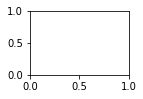

In [0]:
def displayer(x) : 
  img_test = train_x[(train_y.iloc[:,x] == 1)].astype("uint8")
  img_test=  255-pd.DataFrame(colorscaler.fit_transform(img_test), columns=img_test.columns)
  imgplot = plt.imshow(img_test)
  plt.show()
plt.figure(1,)
plt.subplot(3,3,9)



*Netork Building*

In [0]:
#@title MLP
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(93,)))
network.add(Dropout(0.5))
network.add(layers.Dense(128, activation='relu'))
network.add(Dropout(0.5))
network.add(layers.Dense(9, activation='softmax'))
network.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Fitting the network with training data

In [0]:
network.fit(X_train,y_train, epochs=50, batch_size=128, validation_split=0.2)

Testing the network with testing data

In [0]:
test_loss, test_acc = network.evaluate(X_test, y_test)
test_loss, test_acc

20420/20420 [==============================] - 1s 38us/step


(0.527883425025118, 0.7976493633692459)

In [0]:
#@title KNN


In [0]:

neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = neigh.fit(X_train,y_train)

In [0]:
neigh.score(X_test, y_test)


0.7552399608227228

In [0]:
#@title Support Vctor Machins

In [0]:

classif = svm.SVC(kernel='linear')
classif_score =classif.fit(train_org_x, train_org_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
classif.score(test_org_x,test_org_y)

0.7697355533790402

In [0]:
#classif_score = classif_score.decision_function(test_org_x)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(test_org_y[:, i], classif_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr[0], tpr[0]
   

ValueError: ignored

In [0]:
#@title Random Forest Classifier

In [0]:
clf = RandomForestClassifier(n_estimators=15, random_state = 20)
clf_model = clf.fit(X_train, y_train)


In [0]:
clf.score(X_test, y_test)

In [0]:
import xgboost as xgb

In [0]:
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)

In [0]:
clf.fit(train_org_x,train_org_y)
print(clf.best_score_)
print(clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.5min finished


0.7218799034925762
{'max_depth': 6, 'n_estimators': 200}
